# Exercise: Analysis and visualization of output data

- Generate 1000 scenarios for the flu model given the uncertainties specified (see ./model), or load the results found in ./data. 

In [2]:
from ema_workbench import load_results

results = load_results('./data/1000RunsPerPolicyFlu.tar.gz')

- What are the uncertainties, outcomes of interest and policies?

In [3]:
len(results)

2

apparently results is a tuple or list with length 2. If we look at the documentation for [`perform_experiments`](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/evaluators.html#ema_workbench.em_framework.evaluators.perform_experiments) we see a more detaile description of what is in this tuple. 

In [4]:
experiments, outcomes = results
print(type(experiments))
print(type(outcomes))

<class 'numpy.ndarray'>
<class 'dict'>


We can easily access the names of the columns in the experiments array accordingly.

In [5]:
experiments.dtype.names

('additional seasonal immune population fraction R1',
 'additional seasonal immune population fraction R2',
 'fatality rate region 2',
 'fatality ratio region 1',
 'infection rate region 2',
 'infection ratio region 1',
 'initial immune fraction of the population of region 1',
 'initial immune fraction of the population of region 2',
 'normal contact rate region 1',
 'normal contact rate region 2',
 'normal interregional contact rate',
 'permanent immune population fraction R1',
 'permanent immune population fraction R2',
 'recovery time region 1',
 'recovery time region 2',
 'root contact rate region 1',
 'root contact ratio region 2',
 'susceptible to immune population delay time region 1',
 'susceptible to immune population delay time region 2',
 'model',
 'policy')

and do the same for the outcomes

In [7]:
print(list(outcomes.keys()))

['TIME', 'deceased population region 1', 'infected fraction R1', 'max infection fraction', 'time of max']


- How many time steps are there in each simulation (extract this from the output rather than opening the vensim model)?

we can simpy print the shape of the outcomes and the experiment. We see that we have 3000 experiments, and 769 timesteps in the outcomes.

In [9]:
print('experiments', experiments.shape)

for key, value in outcomes.items():
    print(key, value.shape)

experiments (3000,)
TIME (3000, 769)
deceased population region 1 (3000, 769)
infected fraction R1 (3000, 769)
max infection fraction (3000,)
time of max (3000,)


- Considering their end states, which outcomes of interest are negatively correlated?

for this we need to extract the data from the dict. If the shape of the array is 2d, we need the end state, otherwise we can use it as is. Next, we can cast this to a dataframe and use the inbuilt dataframe option to get the correlations.

In [10]:
data = {}
for k,v in outcomes.items(): 
    if k == 'TIME': 
        continue # we don't need time
    
    if len(v.shape) > 1:
        v = v[:,-1]
    data[k] = v

data = pd.DataFrame.from_dict(data)

In [11]:
data.corr()

,deceased population region 1,infected fraction R1,max infection fraction,time of max
deceased population region 1,1.000000,-0.001964,0.711623,-0.020454
infected fraction R1,-0.001964,1.000000,-0.018469,0.200314
max infection fraction,0.711623,-0.018469,1.000000,-0.076894
time of max,-0.020454,0.200314,-0.076894,1.000000


- Considering only the 'no policy' scenarios, how do *infected fraction* and *deceased population* relate over time?  

*hint: use [logical indexing](https://docs.scipy.org/doc/numpy-1.14.0/reference/arrays.indexing.html#boolean-array-indexing)*

In [12]:
print(set(experiments['policy']))

{'adaptive policy', 'static policy', 'no policy'}


In [13]:
logical_index = experiments['policy']=='no policy'
no_policy_experiments = experiments[logical_index]
no_policy_outcomes = {k:v[logical_index] for k,v in outcomes.items()}

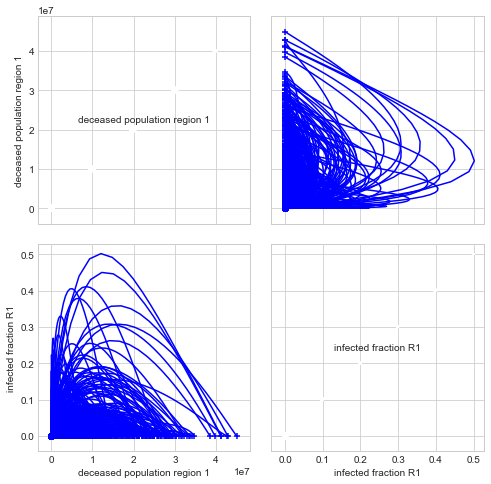

In [25]:
from ema_workbench.analysis import pairs_plotting

no_policy_results = no_policy_experiments, no_policy_outcomes
fig, axes = pairs_plotting.pairs_lines(no_policy_results)
fig.set_size_inches(8,8)
plt.show()

- For the no policy results, visualize the envelope of outcomes for *infected fraction* over time, together with individual scenarios corresponding to the following region: 

    - *time of max* < 10
    - **and** *max infection fraction* > 0.4
 
*hint: look at the documentation of the plotting modules that come with the workbench*
 
answering this requires diving into the documentation of the workbench. There is a single function which does what we need. 

In [15]:
time_of_max = no_policy_outcomes['time of max']
max_infected = no_policy_outcomes['max infection fraction']

logical = (time_of_max < 10) & (max_infected > 0.4)

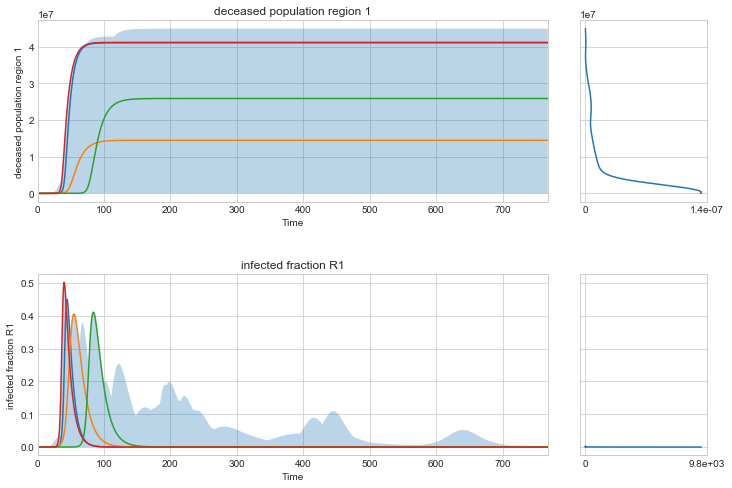

In [21]:
from ema_workbench.analysis import plotting

no_policy_results = no_policy_experiments, no_policy_outcomes

fig, axes = plotting.lines(no_policy_results, density='kde', 
                           experiments_to_show=logical, show_envelope=True)
fig.set_size_inches(12, 8)

plt.show()


- For all results, visualize the end states of the outcome indicators *infected fraction*, *deceased population* and *time of max* on a single plot; where the results are grouped by policies, and for each policy, according to the following conditions:

    - *infected fraction R1* at the 100th timestep > 0.1
    - **and** *infection ratio region 1* > 0.1 (note that *infection ratio region 1* is an uncertainty)
    
The question specifies 3 dimensions, so we need a 3d scatter plot. We can do this with matplotlib. We assign each outcome of interest to a dimension (x, y, z), we can use color to distinguish policies, and shape to specify the specific subset of outcomes.

In the code, I am using [seaborn](https://seaborn.pydata.org/tutorial/color_palettes.html) to generate a nice colormap, by using a predefined [colorbrewer](http://colorbrewer2.org/#type=qualitative&scheme=Dark2&n=3) colormap.


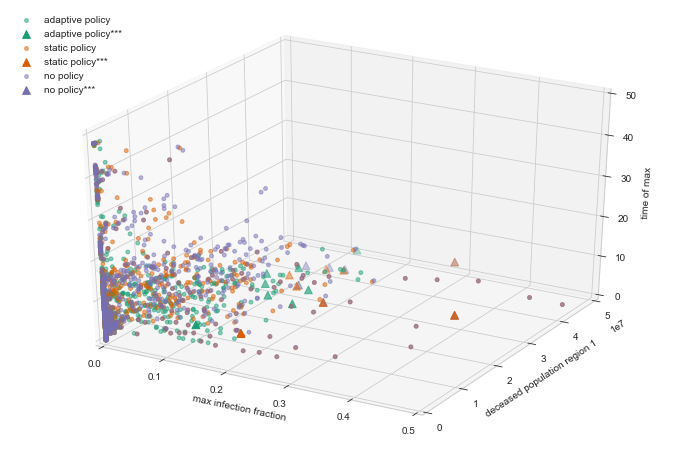

In [37]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = sns.color_palette('Dark2', 3)
markers = ['o', '^']
oois = ['max infection fraction', 'deceased population region 1','time of max']

ax.set_xlabel(oois[0])
ax.set_ylabel(oois[1])
ax.set_zlabel(oois[2])

for p, policy in enumerate(set(experiments['policy'])):
    logical = experiments['policy']==policy
    new_outcomes = {key:value[logical] for key, value in outcomes.items()}
    new_experiments = experiments[logical]
    
    logical_index = (new_outcomes['infected fraction R1'][:, 99]>0.1) &\
                    (new_experiments['infection ratio region 1']>0.1)
    
    x_ = new_outcomes[oois[0]][logical_index]
    x = new_outcomes[oois[0]][~logical_index]
    
    y_ = new_outcomes[oois[1]][logical_index,-1]
    y = new_outcomes[oois[1]][~logical_index,-1]
    
    z_ = new_outcomes[oois[2]][logical_index]
    z = new_outcomes[oois[2]][~logical_index]
    
    ax.scatter(x, y, z, c=colors[p], marker=markers[0], alpha=0.5, s=15, label=policy)
    ax.scatter(x_, y_, z_, c=colors[p], marker=markers[1], s=60, label=policy+'***')

ax.legend(loc=2, scatterpoints = 1)
ax.set_xlim([0, 0.5])
ax.set_ylim([0, 5e+07])
ax.set_zlim([0, 50])
fig.set_figheight(8)
fig.set_figwidth(12)

plt.show()